# Irradiated Monkeys Cont.
In this notebook I will elaborte on the work with the A_monkeys_preliminary findings

Specifically, I will focus on the following:

1.) Using Regression for continuous variables, forcasting variables, & clustering through other means

2.) Combining the biomarker and health-outcome data in more complex ways 

3.) Utilizing dimentionality reduction for vizualization and training

4.) Automate the cycling through of predictions

In [1]:
# handling data
import pandas as pd
import numpy as np
import datetime

# visualizing data
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

# Statistics
from scipy import stats
#import statsmodels.api as sm
#import statsmodels.imputation.mice as smi
#import scipy.cluster.hierarchy as hac
#from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.gridspec as gridspec
import math
import random


#SHAP Value stuff
import shap
from shap import TreeExplainer
from shap import GradientExplainer
from shap import DeepExplainer
from shap import KernelExplainer
from shap import SamplingExplainer
from shap import PartitionExplainer

#ML stuff
import catboost
from catboost import CatBoostClassifier, Pool, CatBoostRegressor, CatBoost

#language handling
#import bert


#from mxnet import nd, autograd, gluon
#from mxnet.gluon import nn, rnn
#import mxnet as mx

#fix the error that pops up about ipwydgets 
from tqdm import tqdm
#from .autonotebook import tqdm as notebook_tqdm

print("Setup Complete")


/Users/aidanlew/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup Complete


In [2]:
pwd

'/Users/aidanlew/Desktop/cmb/codes/monkey_irrad_sept-2022'

In [3]:
cd '/Users/aidanlew/Documents'

/Users/aidanlew/Documents


In [4]:
def parser(x):
    return datetime.datetime.strptime(x,'%d-%m-%y')


# Regression, forcasting, & clustering

## 1.) Regression prediction for continuous variables

## Data loading

In [5]:
#Makee a df were all the data is present (except irrad data for the controls)
minhealth_monkey_df = pd.read_excel('../Documents/demographic_data_r2.xlsx',
                    sheet_name=1,
                    skiprows = 0,
                    #usecols = ,
                    engine = 'openpyxl',
                    date_parser=parser
                         )

#Set the index to the monkey ID and make the labels not read as integers
#minhealth_monkey_df.set_index(['ID'])
#minhealth_monkey_df['ID'] = health_monkey_df['ID'].astype(str)

#health_monkey_df.columns
minhealth_monkey_df.head(10)

# Turn the Y/N to 1/0 and LIVING/DECESED to 1/0
#copy over the OG df
minmod_health_monkey_df = minhealth_monkey_df.copy()

# Y to 1
# For some reason, multiple columns together is seen as a df and .map() doesn't work
# Need to do the .map() before the .fillna()
minmod_health_monkey_df['Diabetes_(Y/N)'] = minmod_health_monkey_df['Diabetes_(Y/N)'].map({'Y': 1})
minmod_health_monkey_df['Cataracts_(Y/N)'] = minmod_health_monkey_df['Cataracts_(Y/N)'].map({'Y': 1})
minmod_health_monkey_df['Arthritis_(Y/N)'] = minmod_health_monkey_df['Arthritis_(Y/N)'].map({'Y': 1})
minmod_health_monkey_df['Periodontitis_(Y/N)'] = minmod_health_monkey_df['Periodontitis_(Y/N)'].map({'Y': 1})
minmod_health_monkey_df['GI_(Y/N)'] = minmod_health_monkey_df['GI_(Y/N)'].map({'Y': 1})
minmod_health_monkey_df['Behavior_(Y/N)'] = minmod_health_monkey_df['Behavior_(Y/N)'].map({'Y': 1})
minmod_health_monkey_df['Tumor_(Y/N)'] = minmod_health_monkey_df['Tumor_(Y/N)'].map({'Y': 1})
minmod_health_monkey_df['Heart_(Y/N)'] = minmod_health_monkey_df['Heart_(Y/N)'].map({'Y': 1})
minmod_health_monkey_df['Hypertension_(Y/N)'] = minmod_health_monkey_df['Hypertension_(Y/N)'].map({'Y': 1})
minmod_health_monkey_df['Testicular Atrophy_(Y/N)'] = minmod_health_monkey_df['Testicular Atrophy_(Y/N)'].map({'Y': 1})
minmod_health_monkey_df['Ovarian Dysfunction_(Y/N)'] = minmod_health_monkey_df['Ovarian Dysfunction_(Y/N)'].map({'Y': 1})
minmod_health_monkey_df['Hepatic_(Y/N)'] = minmod_health_monkey_df['Hepatic_(Y/N)'].map({'Y': 1})
minmod_health_monkey_df['Kidney_(Y/N)'] = minmod_health_monkey_df['Kidney_(Y/N)'].map({'Y': 1})
minmod_health_monkey_df['Lung_(Y/N)'] = minmod_health_monkey_df['Lung_(Y/N)'].map({'Y': 1})
minmod_health_monkey_df['Bone_(Y/N)'] = minmod_health_monkey_df['Bone_(Y/N)'].map({'Y': 1})
minmod_health_monkey_df['Overweight_(Y/N)'] = minmod_health_monkey_df['Overweight_(Y/N)'].map({'Y': 1})
minmod_health_monkey_df['Underweight_(Y/N)'] = minmod_health_monkey_df['Underweight_(Y/N)'].map({'Y': 1})
minmod_health_monkey_df['Brain Lesion_(Y/N)'] = minmod_health_monkey_df['Brain Lesion_(Y/N)'].map({'Y': 1})


# NaN to 0
minmod_health_monkey_df[['Diabetes_(Y/N)', 'Cataracts_(Y/N)', 'Arthritis_(Y/N)',
       'Periodontitis_(Y/N)', 'GI_(Y/N)', 'Behavior_(Y/N)', 'Tumor_(Y/N)',
       'Heart_(Y/N)', 'Hypertension_(Y/N)', 'Testicular Atrophy_(Y/N)',
       'Ovarian Dysfunction_(Y/N)', 'Hepatic_(Y/N)', 'Kidney_(Y/N)',
       'Lung_(Y/N)', 'Bone_(Y/N)', 'Overweight_(Y/N)', 'Underweight_(Y/N)',
       'Brain Lesion_(Y/N)']]= minmod_health_monkey_df[['Diabetes_(Y/N)', 'Cataracts_(Y/N)', 'Arthritis_(Y/N)',
       'Periodontitis_(Y/N)', 'GI_(Y/N)', 'Behavior_(Y/N)', 'Tumor_(Y/N)',
       'Heart_(Y/N)', 'Hypertension_(Y/N)', 'Testicular Atrophy_(Y/N)',
       'Ovarian Dysfunction_(Y/N)', 'Hepatic_(Y/N)', 'Kidney_(Y/N)',
       'Lung_(Y/N)', 'Bone_(Y/N)', 'Overweight_(Y/N)', 'Underweight_(Y/N)',
       'Brain Lesion_(Y/N)']].fillna(0, #inplace=True
)

#LIVING/DECESED to 1/0
minmod_health_monkey_df['Animal_Status'] = minmod_health_monkey_df['Animal_Status'].map({'LIVING':1, 'DECEASED': 0})


#minmod_health_monkey_df.head(10)
minmod_health_monkey_df.columns

Index(['ID', 'Time_Under_Observation_(yrs)', 'Dose_(Gy)', 'Irrad_Age_(months)',
       'Years_Since_Irrad', 'Current_Age_(years)', 'Animal_Status',
       'Diabetes_(Y/N)', 'Cataracts_(Y/N)', 'Arthritis_(Y/N)',
       'Periodontitis_(Y/N)', 'GI_(Y/N)', 'Behavior_(Y/N)', 'Tumor_(Y/N)',
       'Heart_(Y/N)', 'Hypertension_(Y/N)', 'Testicular Atrophy_(Y/N)',
       'Ovarian Dysfunction_(Y/N)', 'Hepatic_(Y/N)', 'Kidney_(Y/N)',
       'Lung_(Y/N)', 'Bone_(Y/N)', 'Overweight_(Y/N)', 'Underweight_(Y/N)',
       'Brain Lesion_(Y/N)'],
      dtype='object')

In [6]:
#Makee a df were all the data is present (except irrad data for the controls)
minbio_monkey_df = pd.read_excel('../Documents/full_monkey_data_r2.xlsx',
                    #sheet_name=1,
                    skiprows = 0,
                    usecols = ['ID', 'Species', 'SAMPLE_DATE', 'IRRAD', 'IRRAD_DATE', 'DOB', 'SEX',
       'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'WBC_(K/uL)', 'RBC_(M/uL)', 'Hemaglobin_(HGB_g/dL)',
       'Hemocrit_(HCT_%)', 'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
                    engine = 'openpyxl',
                    date_parser=parser
                         )

#Set the index to the monkey ID and make the labels not read as integers
minbio_monkey_df.set_index(['ID'])
minbio_monkey_df['ID'] = minbio_monkey_df['ID'].astype(str)

#minbio_monkey_df.dropna(axis=0, inplace=True) 

#minbio_monkey_df.columns
minbio_monkey_df.tail()


Cannot parse header or footer so it will be ignored


,ID,Species,SAMPLE_DATE,IRRAD,IRRAD_DATE,DOB,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
4547,2112,Rhesus-Chinese,2020-09-23 00:00:00,No,NaT,1999-09-28,M,Research,NaN,NaN,...,67.0,6.2,1.1,0.0,1696,4422,409,73,0,289
4548,2112,Rhesus-Chinese,2021-03-04 00:00:00,No,NaT,1999-09-28,M,Research,NaN,NaN,...,56.1,9.1,1.5,0.0,1312,2210,359,59,0,284
4549,2210,Rhesus-Indian,2021-09-07 00:00:00,No,NaT,1999-01-01,F,Research,NaN,NaN,...,26.8,12.3,1.2,0.0,3104,1394,640,62,0,311
4550,2210,Rhesus-Indian,2021-09-20 00:00:00,No,NaT,1999-01-01,F,Research,NaN,NaN,...,36.2,10.9,1.7,0.0,2970,2100,632,99,0,348
4551,2210,Rhesus-Indian,2021-10-07 00:00:00,No,NaT,1999-01-01,F,Research,NaN,NaN,...,16.0,21.0,3.0,0.0,3360,896,1176,168,0,329


In [34]:
single_minbio_df = minbio_monkey_df.copy()
single_minbio_df = single_minbio_df[single_minbio_df['ID'] == '2046']
single_minbio_df.set_index(['ID'])
#single_minbio_df.reset_index()
single_minbio_df.head()

,ID,Species,SAMPLE_DATE,IRRAD,IRRAD_DATE,DOB,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
33,2046,Rhesus-Chinese,2017-11-02 00:00:00,Yes,2014-04-09,2007-07-03,F,Clinical,1303.0,43.0,...,44.6,5.5,0.5,0.0,1877,1695,209,19,0,276
34,2046,Rhesus-Chinese,2017-12-13 00:00:00,Yes,2014-04-09,2007-07-03,F,Clinical,1344.0,44.0,...,40.5,7.4,0.0,0.0,3647,2835,518,0,0,386
35,2046,Rhesus-Chinese,2018-01-02 00:00:00,Yes,2014-04-09,2007-07-03,F,Research,1364.0,45.0,...,39.9,6.0,0.3,0.3,2140,1596,240,12,12,309
36,2046,Rhesus-Chinese,2018-01-31 00:00:00,Yes,2014-04-09,2007-07-03,F,Research,1393.0,46.0,...,46.8,5.6,0.5,0.0,2025,2012,241,22,0,275
37,2046,Rhesus-Chinese,2018-04-05 00:00:00,Yes,2014-04-09,2007-07-03,F,Research,1457.0,48.0,...,22.8,5.8,0.1,0.1,6123,1961,499,9,9,325


### Single Monkey

#### Data processing for ML

In [35]:
#make a parent df
single_minbio_df.copy()
sreg_df = single_minbio_df
#sreg_df.tail(2)

#make train/testdf
(sreg_train_df, sreg_test_df)= sreg_df, sreg_df

#sreg_test_df.tail(2)

# label values extraction
sreg_y=sreg_train_df['LYMPHOCYTES_(%)']
sreg_X=sreg_train_df.drop(['ID','IRRAD_DATE','DOB','SAMPLE_DATE','LYMPHOCYTES_(%)'],axis=1)

#sreg_y.tail()
#sreg_X.columns

#sreg_y.to_numpy()

# Declare catagorical features - first column
cat_features= list(range(0,sreg_X[sreg_X.columns[:4]].shape[1]))

print(cat_features)

# all of our labels are catagorical

[0, 1, 2, 3]


In [36]:
from catboost import Pool
from sklearn.model_selection import train_test_split

#put the data into the pool
sreg_pool = Pool(data=sreg_X, label=sreg_y, cat_features=cat_features)


#train tesr split - 30% test
sreg_data= train_test_split(sreg_X, sreg_y, test_size=0.3, random_state=0)

#### The order of this matters###
sreg_X_train, sreg_X_validation,sreg_y_train, sreg_y_validation= sreg_data

sreg_train_pool = Pool(
    data = sreg_X_train,
    label = sreg_y_train,
    cat_features = cat_features
)

sreg_validation_pool = Pool(
    data = sreg_X_validation,
    label = sreg_y_validation,
    cat_features = cat_features
)


iteritems is deprecated and will be removed in a future version. Use .items instead.


#### Model Formation

In [51]:
from catboost import CatBoostRegressor

# Model for predicting lymphocyte counts for a singel monkey
model7= CatBoostRegressor(iterations=4,
    learning_rate=0.5,
    #loss_function='MultiClass',
    #custom_loss=['AUC','Accuracy'],
    early_stopping_rounds=5,
    #use_best_model=True,
    #save_snapshot = True,
    #snapshot_file='monkey_snapshot.bkp',
    #interval is seconds
    #snapshot_interval=120
)


model7.fit(sreg_X, 
           sreg_y, 
           cat_features=cat_features,
           #plot=True,
           verbose=100 #tells how many iterations to print
         )

####1000 iter gives R2=1
###1 iter gives R2=0.057
###2 iters gives R2=0.51
###3 iters gives R2=0.65
###4 iters gives R2=0.81
###10 iters gives r2=0.99

0:	learn: 11.2460441	total: 1.08ms	remaining: 3.24ms
3:	learn: 6.6995911	total: 3.77ms	remaining: 0us


iteritems is deprecated and will be removed in a future version. Use .items instead.


#### Predictions

In [52]:
from sklearn.metrics import r2_score
#Predict the test Lymphocyte percentages

sreg_a = model7.predict(sreg_X_validation)
print(len(sreg_a), 
     )
sreg_a_df = pd.DataFrame(sreg_a)
print(sreg_a_df)
print(sreg_y_validation)

#r2 is the best metric for accuracy of predictions with continuous data
print('The r2 score for the model is:',r2_score(sreg_y_validation, sreg_a_df))


6
           0
0  38.461159
1  34.138359
2  25.000642
3  25.000642
4  37.707235
5  28.851855
34    40.5
39    35.1
41    21.8
43    20.1
47    38.2
37    22.8
Name: LYMPHOCYTES_(%), dtype: float64
The r2 score for the model is: 0.8186409651750879


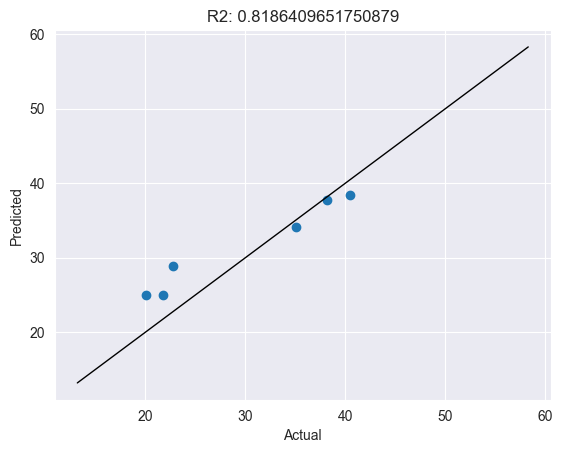

In [53]:
# Plot the predictions vs. actual with the R2 score

fig, ax = plt.subplots()
ax.scatter(sreg_y_validation, sreg_a_df)


ax.plot([sreg_y.min(), sreg_y.max()], [sreg_y.min(), sreg_y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
#regression line
#single_y_validation, single_a_df = single_y_validation.reshape(-1,1), single_a_df.reshape(-1,1)
#ax.plot(single_y_validation, LinearRegression().fit(single_y_validation, single_a_df).predict(single_y_validation))



ax.set_title('R2: ' + str(r2_score(sreg_y_validation, sreg_a_df)))


plt.show()

#### Feature importance

In [35]:
# Find the feature importance for predicting the lmphocyte counts is a single monkey
model7.get_feature_importance(data=sreg_pool,
                       #reference_data=None,
                       #type=EFstrType.ShapValues,
                       prettified=True,
                       #thread_count=-1,
                       #verbose=False,
                       #log_cout=sys.stdout,
                       #log_cerr=sys.stderr
)


,Feature Id,Importances
0,NEUT_(%),26.502043
1,TYPE,12.952220
2,ABS_LYMPH_(/uL),12.820068
3,EOS_(%),11.754037
4,RBC_(M/uL),11.554449
5,Hemocrit_(HCT_%),4.840888
6,Mean_corpuscular_hemaglobin_concentration_(MCH...,4.300688
7,MONTHS_SINCE_IRRAD,3.765854
8,WBC_(K/uL),3.296789
9,ABS_NEUT_(/uL),2.958379


### Multi Monkey

#### Data processing for ML

In [7]:
#make a parent df
minbio_monkey_df.copy()
mreg_df = minbio_monkey_df
#sreg_df.tail(2)

#make train/testdf
(mreg_train_df, mreg_test_df)= mreg_df, mreg_df

#mreg_test_df.tail(2)

# label values extraction
mreg_y=mreg_train_df['LYMPHOCYTES_(%)']
mreg_X=mreg_train_df.drop(['ID','IRRAD_DATE','DOB','SAMPLE_DATE','LYMPHOCYTES_(%)'],axis=1)

#mreg_y.tail()
#mreg_X.columns

#mreg_y.to_numpy()

# Declare catagorical features - first column
cat_features= list(range(0,mreg_X[mreg_X.columns[:4]].shape[1]))

print(cat_features)

# all of our labels are catagorical

[0, 1, 2, 3]


In [10]:
#put the data into the pool
mreg_pool = Pool(data=mreg_X, label=mreg_y, cat_features=cat_features)


#train tesr split - 30% test
mreg_data= train_test_split(mreg_X, mreg_y, test_size=0.3, random_state=0)

#### The order of this matters###
mreg_X_train, mreg_X_validation,mreg_y_train, mreg_y_validation= mreg_data

mreg_train_pool = Pool(
    data = mreg_X_train,
    label = mreg_y_train,
    cat_features = cat_features
)

mreg_validation_pool = Pool(
    data = mreg_X_validation,
    label = mreg_y_validation,
    cat_features = cat_features
)


#### Model Formation

In [29]:
# rEgression for multiple monkey predicitons
model8= CatBoostRegressor(iterations=2,
    learning_rate=0.5,
    #loss_function='MultiClass',
    #custom_loss=['AUC','Accuracy'],
    early_stopping_rounds=5,
    #use_best_model=True,
    #save_snapshot = True,
    #snapshot_file='monkey_snapshot.bkp',
    #interval is seconds
    #snapshot_interval=120
)

model8.fit(mreg_X, 
           mreg_y, 
           cat_features=cat_features, 
          # verbose=100 #tells how many iterations to print
         )
### 200 iters takes 3 seconds and gives 0.2436142 loss
### 1000 iters takes 12 seconds and gives 0.0214503 loss
### 10000 iters takes 1.5 min and has 2.8X10^-6 loss 

#### 200 gives very accurate results for predicting lymphocyte %
### 100 gives R2 of almost 1
# 10 iterations gives R2 of 0.98
# 1 iteration gives R2 of 0.65!!!
# 2 iterations gives R2 of 0.86!!!!!

0:	learn: 8.9546285	total: 5.47ms	remaining: 5.47ms
1:	learn: 5.6638343	total: 11.6ms	remaining: 0us


iteritems is deprecated and will be removed in a future version. Use .items instead.


#### Predictions

In [30]:
#Predict the test Lymphocyte percentages

mreg_a = model8.predict(mreg_X_validation)
print(len(mreg_a), 
     )
mreg_a_df = pd.DataFrame(mreg_a)
print(mreg_a_df)
print(mreg_y_validation)

#r2 is the best metric for accuracy of predictions with continuous data
print('The r2 score for the model is:',r2_score(mreg_y_validation, mreg_a_df))


1366
              0
0     25.063984
1     33.297072
2     33.856488
3     19.552263
4     54.607206
...         ...
1361  43.169901
1362  41.091966
1363  20.654231
1364  43.484515
1365  42.307342

[1366 rows x 1 columns]
2438    17.9
3343    36.1
1895    36.0
3501    10.2
3256    61.1
        ... 
3878    49.0
3037    39.0
4250    15.3
1770    46.4
2735    44.1
Name: LYMPHOCYTES_(%), Length: 1366, dtype: float64
The r2 score for the model is: 0.8601945571118528


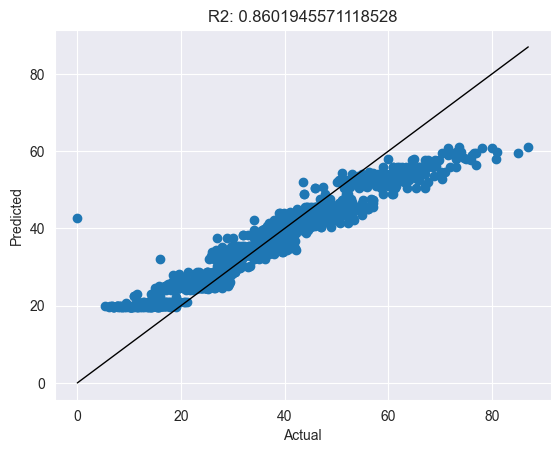

In [31]:
# Plot the predictions vs. actual with the R2 score

fig, ax = plt.subplots()
ax.scatter(mreg_y_validation, mreg_a_df)


ax.plot([mreg_y.min(), mreg_y.max()], [mreg_y.min(), mreg_y.max()], 
        'k-', 
        linewidth=1, 
        markersize=120
)

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
#regression line
#single_y_validation, single_a_df = single_y_validation.reshape(-1,1), single_a_df.reshape(-1,1)
#ax.plot(single_y_validation, LinearRegression().fit(single_y_validation, single_a_df).predict(single_y_validation))



ax.set_title('R2: ' + str(r2_score(mreg_y_validation, mreg_a_df)))


plt.show()

#### Feature Analysis

In [32]:
# Find the feature importance for predicting the lmphocyte counts is a single monkey
model8.get_feature_importance(data=mreg_pool,
                       #reference_data=None,
                       #type=EFstrType.ShapValues,
                       prettified=True,
                       #thread_count=-1,
                       #verbose=False,
                       #log_cout=sys.stdout,
                       #log_cerr=sys.stderr
)


,Feature Id,Importances
0,NEUT_(%),92.324836
1,ABS_LYMPH_(/uL),3.185803
2,ABS_MONO_(/uL),2.682848
3,EOS_(%),1.198216
4,Hemaglobin_(HGB_g/dL),0.559005
5,Mean_corpuscular_volume_(MCV_fL),0.049293
6,Species,0.000000
7,IRRAD,0.000000
8,SEX,0.000000
9,TYPE,0.000000


### Summary
Using Regression for predicitng values generates more accurate (based on iterations) and much quiker results compared to classifier. It is interesting how the feature importance does change a little though. Even with all the biological data, only 2 iterations gives R2=0.86 which is absolutely insane. I think this is probably due to the amount of data. This is very promising for the power of these models and the scalability of the applications.

# Combining data
Fusing the biomarker and health data in the following ways for more robust predicitons/pattern recognition:

1.) Non-datetime biomarker data with the binary health outcome data

2.) Datetime biomarker and health outcome data

3.) Datetime biomarker and health coutcome data with the more subjective text

## 1.) Datetime biomarker and health outcome data
 

## Concatonating data
Pandas has a .join(), .merge(), and .concat() methods

Need to either delete or ovelap the ID, Dose_(Gy), Irrad_Age_(months), Years_Since_Irrad, AGE, and the equivilents.

Issue: not all monkeys are accounted for in the health data, and there are far more samples in the bio data - make sure it fills down??? based on date???


In [15]:
minbio_monkey_df.join(minmod_health_monkey_df, on='ID',rsuffix='_right')

,ID,Species,IRRAD,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,MONTHS AT IRRAD,DOSE_(Gy),AGE,...,Hypertension_(Y/N),Testicular Atrophy_(Y/N),Ovarian Dysfunction_(Y/N),Hepatic_(Y/N),Kidney_(Y/N),Lung_(Y/N),Bone_(Y/N),Overweight_(Y/N),Underweight_(Y/N),Brain Lesion_(Y/N)
0,2061,Rhesus-Chinese,No,F,Clinical,NaN,NaN,NaN,NaN,10.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2061,Rhesus-Chinese,No,F,Research,NaN,NaN,NaN,NaN,10.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2061,Rhesus-Chinese,No,F,Research,NaN,NaN,NaN,NaN,10.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2061,Rhesus-Chinese,No,F,Research,NaN,NaN,NaN,NaN,11.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2061,Rhesus-Chinese,No,F,Research,NaN,NaN,NaN,NaN,11.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4547,2112,Rhesus-Chinese,No,M,Research,NaN,NaN,NaN,NaN,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4548,2112,Rhesus-Chinese,No,M,Research,NaN,NaN,NaN,NaN,21.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4549,2210,Rhesus-Indian,No,F,Research,NaN,NaN,NaN,NaN,25.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4550,2210,Rhesus-Indian,No,F,Research,NaN,NaN,NaN,NaN,25.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2.) Datetime biomarker and health outcome data



## 3.) Datetime biomarker and health coutcome data with the more subjective text

# Dimentionality reduction
Can I initially reduce the number of features for faster training and better vizualization with the same amount of power?

Using Non-negative matrix factorization (NMF) because it seemed well used and effective
 - however, has to be linearly seperatable

Also using t-Distributed Stochastic Neighbor Embedding (t-SNE) because it works well for non-linear data

Articel on different techniques:
https://neptune.ai/blog/dimensionality-reduction#:~:text=Advantages%20and%20disadvantages-,What%20is%20dimensionality%20reduction%3F,variables%20are%20also%20called%20features.

Sklearn NMF https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

Sklearn TSNE https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html


In [165]:
#get the single monkey data in a form that can be understood by the NMF and TSNE - no text or datetime

single_red_df = single_monkey_df.copy()
single_red_df = single_red_df.drop(['Species','SEX', 'TYPE','IRRAD_DATE','DOB','SAMPLE_DATE',], axis =1)
#single_red_df.head(2)

#Turn 'Yes' and 'No' to 1 & 0 - numerical
single_red_df['IRRAD'] = single_red_df['IRRAD'].map({'Yes': 1, 'No': 0})


single_red_df.head(2)

,ID,IRRAD,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,MONTHS AT IRRAD,DOSE_(Gy),AGE,WBC_(K/uL),RBC_(M/uL),Hemaglobin_(HGB_g/dL),...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
33,2046,1,1303.0,43.0,81.0,1.14,10.3,3.8,6.08,14.2,...,44.6,5.5,0.5,0.0,1877,1695,209,19,0,276
34,2046,1,1344.0,44.0,81.0,1.14,10.4,7.0,5.38,12.2,...,40.5,7.4,0.0,0.0,3647,2835,518,0,0,386


In [167]:
from sklearn.manifold import TSNE

#17 is the max for perplexityin this instance
monkey_tsne = TSNE(n_components=2, 
                   perplexity=17
                   ).fit_transform(single_red_df)


The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


In [171]:
df_subset1 = monkey_tsne[:,0]
df_subset2 = monkey_tsne[:,1]

array([ -58.8492,  -66.9556,   37.9748,   -7.0038,   56.2467,   93.4242,
         79.3676,   31.9424, -101.5552,  108.6782, -100.4777,  -46.1296,
        -50.1352,    1.0581,   13.0641,  -11.5553,  -15.6544,   48.4498],
      dtype=float32)

<AxesSubplot: >

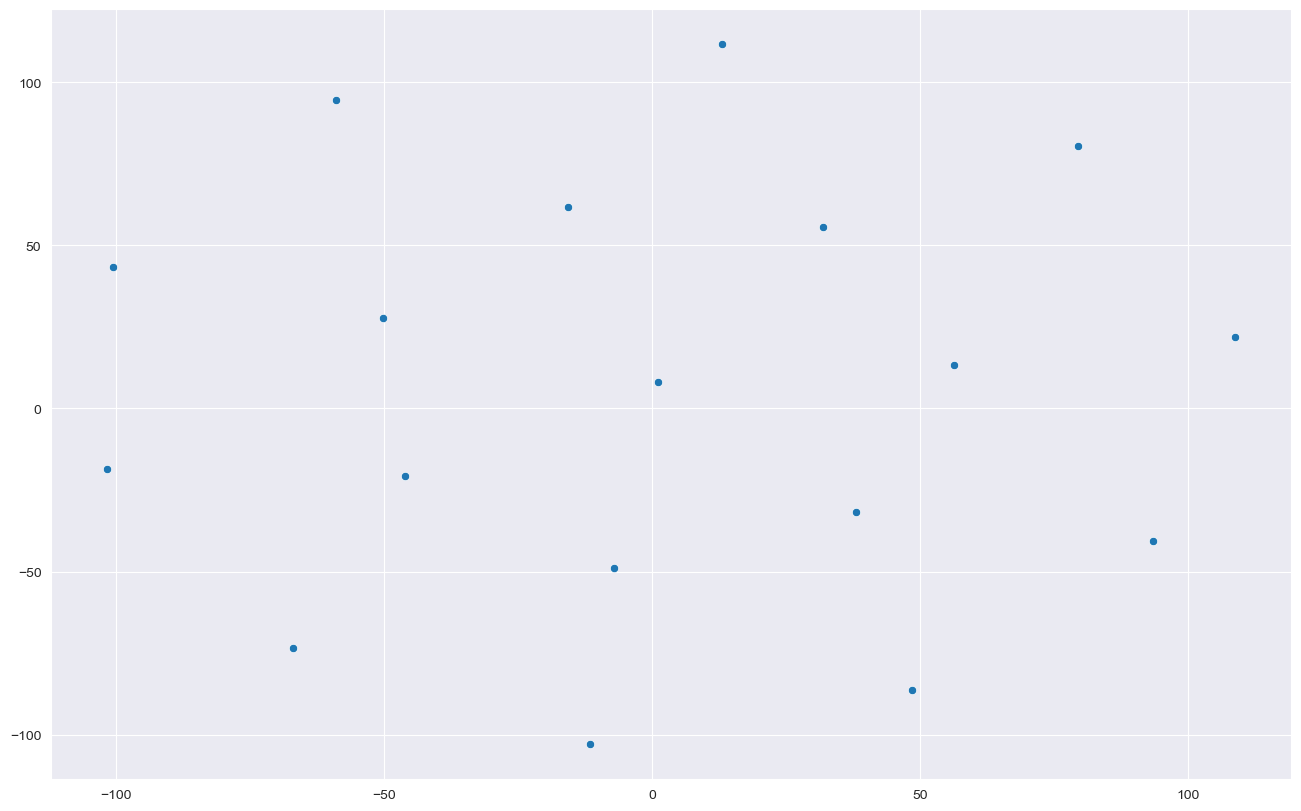

In [186]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=df_subset1, y=df_subset2,
    #hue="y",
    palette=sns.color_palette("hls", 10),
    #data=df_subset,
    legend="full",
    alpha=1
)

## UMAP
Want to try UMAP with the health outcome and combined data

In [32]:
# Same setup as from the docs example: https://umap-learn.readthedocs.io/en/latest/basic_usage.html
import umap.plot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

import umap
reducer = umap.UMAP()



print('Setup Complete')

Setup Complete


In [33]:
#need to scale the vales to z-scores to get them all on the same page

#Make df with the blood analytics with no missing values - NaN as 0, see if there's a better way
minmod_health_monkey_df.copy()
healthumap_df = minmod_health_monkey_df.fillna(0)

#healthumap_df.head()

#Scale the blood to z-scores
healthumap_df = healthumap_df.values
scaled_healthumap_df = StandardScaler().fit_transform(healthumap_df)

In [34]:
# Want it to be (n, 2) for UMAP to work
embedding = reducer.fit_transform(scaled_healthumap_df)
embedding.shape

(152, 2)

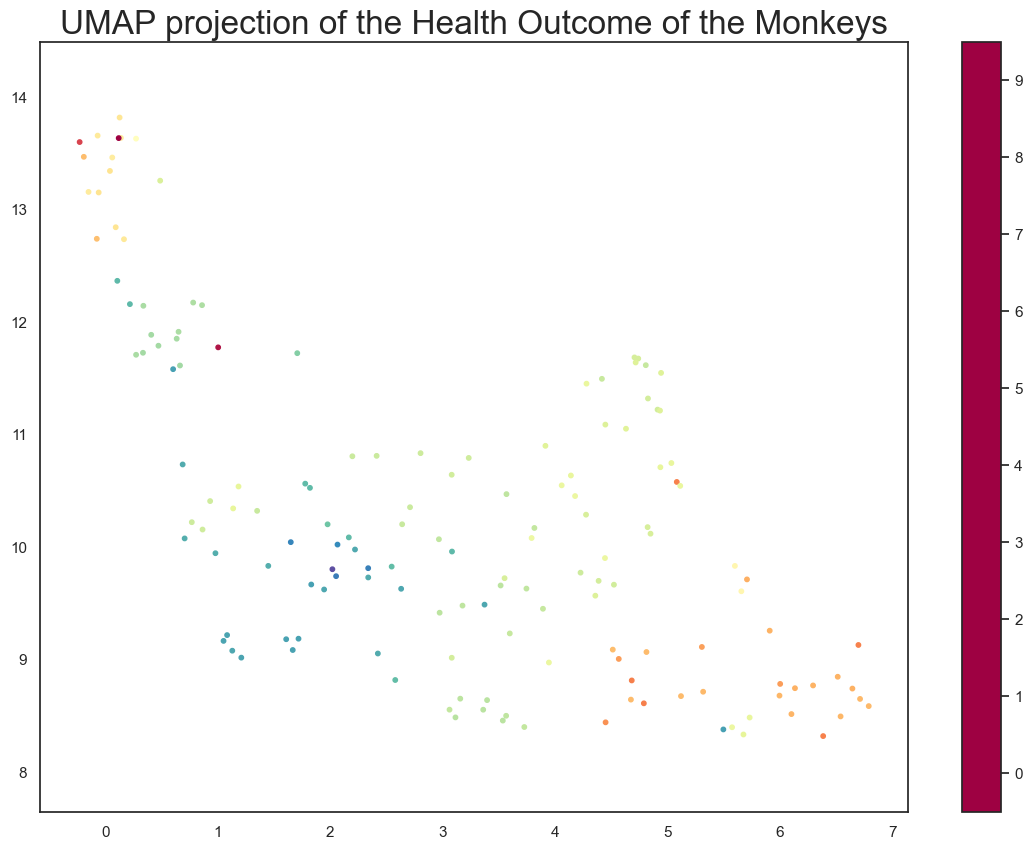

In [39]:
# Simply visualize the UMAP
plt.scatter(embedding[:, 0], 
            embedding[:, 1], 
            c=minmod_health_monkey_df.ID, 
            cmap='Spectral', 
            s=10
           )

#show the spiderweb
#umap.plot.connectivity(mapper, edge_bundling='hammer')

plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the Health Outcome of the Monkeys', fontsize=24);

## Interactive Health outcome UMAP

In [41]:
# Set up interactive loading of 
from io import BytesIO
from PIL import Image
import base64
import bokeh

def embeddable_image(data):
    img_data = 255 - 15 * data.astype(np.uint8)
    image = Image.fromarray(img_data, mode='L').resize((64, 64), Image.Resampling.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

#This part has to go below up above
import bokeh
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10

output_notebook()

Loading BokehJS ...

In [52]:
umap1_df = pd.DataFrame(embedding, columns=('x', 'y'))

datasource = ColumnDataSource(umap1_df)
#color_mapping = CategoricalColorMapper(factors=minmod_health_monkey_df['ID'],
#                                       palette='Turbo256')




plot_figure = figure(
    title='UMAP projection of the Health outcome dataset',
    plot_width=600,
    plot_height=600,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 16px; color: #224499'>Digit:</span>
        <span style='font-size: 18px'>@digit</span>
    </div>
</div>
"""))

plot_figure.circle(
    'x',
    'y',
    source=umap1_df,
    #color=dict(field='digit', #transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=4
)

show(plot_figure)

### It works, but the number of points is so large it gives them all grey colors, might work with just monkeys ###

# Automate cycling through feature predicitons
Instead of seting up a single label-train dynamic, can I predict every single feature based on the same data?

# Conclusions